## Algorithm Hypertuning Using Gridsearch and ML FLow

This notebook demonstrates algorithm exploration part where we have applied 4 different algorithms to the training set

- Logistic Regression (Baseline and Fastest Model)
- Gradient Boosted Tree (Best Results but Resource Intensive)

### Section 1 - Setup Environment

In [0]:
from pyspark.sql.functions import col, concat, count, countDistinct, expr, lit, length, max as pyspark_max, min as pyspark_max, mean, substring, split, sum as pyspark_sum, when, to_utc_timestamp, to_timestamp, unix_timestamp, isnan
import pandas as pd
from html import escape
from IPython.display import HTML, display as ipython_display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType, StringType, BooleanType, DateType, DoubleType
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from pyspark.sql.functions import substring
from pyspark.sql import functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, max, substring
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from sparkdl.xgboost import XgboostClassifier
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import Imputer
from pyspark.ml.classification import LinearSVC as svc
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
import numpy as np
import time
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window


<br>
<img src ='https://sudhritybucket.s3.amazonaws.com/experiments.png' width="800" height="800">
<br>

In [0]:
blob_container = "w261-container" # The name of your container created in https://portal.azure.com
storage_account = "w261storageaccount" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261scope" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

### Section 2 - Load Data

In [0]:
model_data_train = spark.read.parquet(f"{blob_url}/model_train_data_full_v2/*")
model_data_test = spark.read.parquet(f"{blob_url}/model_test_data_full_v2/*")

### Section 3 - Define helper functions

In [0]:
# Helper function 2

def main():

    global eval_metrics
    global eval_predictions
    global eval_model_times
    eval_metrics = {}
    eval_model_times = []
    
    
f1 = 0.0
recall = 0.0
precision = 0.0
sensitivity = 0.0
specificity = 0.0
fp = 0.0
fn = 0.0
model_time = 0.0

metrics = (f1, recall, precision, sensitivity, specificity, fp, fn, model_time)
eval_metrics = {'LR': metrics}
eval_model_times = []

def print_results(predictions, model_name, model_time): 
  """
  Helper function to print evaluation metrics
  """
  tp = predictions[(predictions.departure_delay_boolean == 1) & (predictions.prediction == 1)].count()
  tn = predictions[(predictions.departure_delay_boolean == 0) & (predictions.prediction == 0)].count()
  fp = predictions[(predictions.departure_delay_boolean == 0) & (predictions.prediction == 1)].count()
  fn = predictions[(predictions.departure_delay_boolean == 1) & (predictions.prediction == 0)].count()
  total = predictions.count()
  
  recall = float(tp)/(tp+fn)
  precision = float(tp)/(tp+fp)
  f1 = (2*recall*precision)/(precision+recall)
  
  data = {'Actual-delay': [tp, fn], 'Actual-on time': [fp, tn]}
  confusion_matrix = pd.DataFrame.from_dict(data, orient='index', columns=['Predicted-delay', 'Predicted-on time'])

  print("Sensitivity: {:.2%}".format(tp/(tp + fn)))
  print("Specificity: {:.2%}".format(tn/(tn + fp)))
  print("False positive rate: {:.2%}".format(fp/(fp + tn)))
  print("False negative rate: {:.2%}".format(fn/(tp + fn)))
  print("Recall: {:.2%}".format(recall))
  print("Precision: {:.2%}".format(precision))
  print("f1: {:.2%}".format(f1))
  
  metrics = (round(f1, 2), round(recall, 2), round(precision, 2), round(tp/(tp + fn), 2), \
             round(tn/(tn + fp), 2), round(fp/(fp + tn), 2), round(fn/(tp + fn), 2), round(model_time, 2))
  
  global eval_metrics
  global eval_model_times
  
  eval_metrics[model_name] = metrics
  eval_model_times.append(model_time)
  
  print("########### Confusion Matrix ###########")
  print(confusion_matrix)

### Section 4 - ML Section

**GridSearch implementation**

Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. GridSearch does an exhaustive search that is performed on a the specific parameter values of a model. We will be using Grid search since it can save us time, effort and resources. Experiments results saved in MLFlow were used to modify the algorithms in the Implementation Notebook [here](https://adb-6759024569771990.10.azuredatabricks.net/?o=6759024569771990#notebook/2297543790306469/command/2297543790344697)

### 4.1 Logistic Regression

#### 4.1.1 Logistic regression Hyperparameter tuning

**Logistic Regression Hyperparameter tuning**

In [0]:
grid_search = True

if(grid_search):
  start_grid = time.time()
  
  lr = LogisticRegression(featuresCol='VectorAssembler_features',labelCol='departure_delay_boolean')

  paramGrid_lr = (ParamGridBuilder()
               .addGrid(lr.regParam, [0.1, 0.001])
               .addGrid(lr.fitIntercept, [False, True])
               .addGrid(lr.elasticNetParam, [0, 0.5, 1])
               .addGrid(lr.threshold, [0.45, 0.5, 0.65])
               .addGrid(lr.maxIter, [10, 50])
               .build())
  print(f'paramGrid_lr completed job in {time.time() - start_grid} seconds.')
  paramGrid_time_lr = time.time() - start_grid
  
# Unweighted F1 Scored
  lr_evaluator = MulticlassClassificationEvaluator(labelCol='departure_delay_boolean', metricName='fMeasureByLabel', metricLabel=1, beta=1)
  
#  Weighted F1 Score  
#  lr_evaluator = MulticlassClassificationEvaluator(labelCol='departure_delay_boolean', metricName='f1')

# Area under PR Curve
#   lr_evaluator = BinaryClassificationEvaluator(labelCol="departure_delay_boolean", metricName="areaUnderPR")

  start_cv = time.time()
  lr_cv = CrossValidator(estimator = lr,
                        estimatorParamMaps = paramGrid_lr,
                        evaluator = lr_evaluator,
                        numFolds = 3)

  lr_model = lr_cv.fit(model_data_train)
  print(lr_model)

  print(f'cross validation completed job in {time.time() - start_cv} seconds.')
  lr_time_cv = time.time() - start_cv

paramGrid_lr completed job in 0.012358427047729492 seconds.
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
CrossValidatorModel_abccec46d954
cross validation completed job in 23712.33500266075 seconds.

#### 4.1.2 Logistic Regression Testing

**Hyperparameter tuned for FMeasure - 1**

In [0]:
from pyspark.ml.classification import LogisticRegression
# Setup pipeline

start_lr = time.time()

lr = LogisticRegression(featuresCol='VectorAssembler_features',
                        labelCol='departure_delay_boolean', 
                        regParam = 0.1, 
                        fitIntercept= False, 
                        elasticNetParam=0.0, 
                        maxIter=50, 
                        threshold = 0.45)

stages_lr = [lr]
pipeline_lr = Pipeline(stages=stages_lr)
lr_model = pipeline_lr.fit(model_data_train)
lrPredictions = lr_model.transform(model_data_test)
print(f'lr model completed job in {time.time() - start_lr} seconds.')
lr_time_model = time.time() - start_lr

lr model completed job in 71.580885887146 seconds.

**Logistic Regression Model Evaluation**

In [0]:
# Model Evaluation with scikit learn
y_true_lr = lrPredictions.select(['departure_delay_boolean']).collect()
y_pred_lr = lrPredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_lr, y_pred_lr))
print(confusion_matrix(y_true_lr, y_pred_lr))

precision recall f1-score support

 0.0 0.91 0.63 0.74 5209992
 1.0 0.33 0.74 0.46 1292004

 accuracy 0.65 6501996
 macro avg 0.62 0.68 0.60 6501996
weighted avg 0.79 0.65 0.69 6501996

[[3291925 1918067]
 [ 340698 951306]]

In [0]:
# print results with helper function

print_results(lrPredictions, 'LR', lr_time_model)

Sensitivity: 73.62%
Specificity: 63.21%
False positive rate: 36.79%
False negative rate: 26.38%
Recall: 73.62%
Precision: 33.16%
f1: 45.73%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 951116 340888
Actual-on time 1916856 3293136

Out[8]:

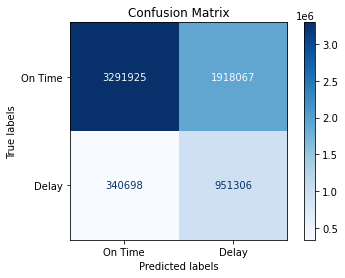

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_lr = confusion_matrix(y_true_lr, y_pred_lr)
cm_lr_display = ConfusionMatrixDisplay(cm_lr, display_labels=['On Time', 'Delay'])
cm_lr_display.plot(cmap='Blues', values_format='d')
cm_lr_display.ax_.set(title='Confusion Matrix')
cm_lr_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')


**Hypertuned for Weighted F1 Score**

In [0]:
# Setup pipeline

start_lr = time.time()

lr = LogisticRegression(featuresCol='VectorAssembler_features',
                        labelCol='departure_delay_boolean', 
                        regParam = 0.001, 
                        fitIntercept= False, 
                        elasticNetParam=0.0, 
                        maxIter=50, 
                        threshold = 0.5)

stages_lr = [lr]
pipeline_lr = Pipeline(stages=stages_lr)
lr_model = pipeline_lr.fit(model_data_train)
lrPredictions = lr_model.transform(model_data_test)
print(f'lr model completed job in {time.time() - start_lr} seconds.')
lr_time_model = time.time() - start_lr

lr model completed job in 82.88261198997498 seconds.

In [0]:
# Model Evaluation with scikit learn
y_true_lr = lrPredictions.select(['departure_delay_boolean']).collect()
y_pred_lr = lrPredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_lr, y_pred_lr))
print(confusion_matrix(y_true_lr, y_pred_lr))

precision recall f1-score support

 0.0 0.90 0.73 0.81 5209992
 1.0 0.38 0.66 0.48 1292004

 accuracy 0.72 6501996
 macro avg 0.64 0.70 0.64 6501996
weighted avg 0.79 0.72 0.74 6501996

[[3816927 1393065]
 [ 440279 851725]]

In [0]:
# print results with helper function

print_results(lrPredictions, 'LR', lr_time_model)

Sensitivity: 65.92%
Specificity: 73.26%
False positive rate: 26.74%
False negative rate: 34.08%
Recall: 65.92%
Precision: 37.94%
f1: 48.16%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 851725 440279
Actual-on time 1393065 3816927

Out[12]:

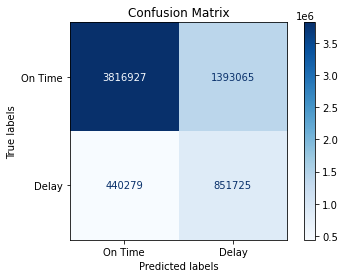

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_lr = confusion_matrix(y_true_lr, y_pred_lr)
cm_lr_display = ConfusionMatrixDisplay(cm_lr, display_labels=['On Time', 'Delay'])
cm_lr_display.plot(cmap='Blues', values_format='d')
cm_lr_display.ax_.set(title='Confusion Matrix')
cm_lr_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')

**Hyperparameter tuned for AUC Precision-Recall**

In [0]:
from pyspark.ml.classification import LogisticRegression
# Setup pipeline

start_lr = time.time()

lr = LogisticRegression(featuresCol='VectorAssembler_features',
                        labelCol='departure_delay_boolean', 
                        regParam = 0.001, 
                        fitIntercept= False, 
                        elasticNetParam=0.0, 
                        maxIter=50, 
                        threshold = 0.45)

stages_lr = [lr]
pipeline_lr = Pipeline(stages=stages_lr)
lr_model = pipeline_lr.fit(model_data_train)
lrPredictions = lr_model.transform(model_data_test)
print(f'lr model completed job in {time.time() - start_lr} seconds.')
lr_time_model = time.time() - start_lr

lr model completed job in 85.56252241134644 seconds.

In [0]:
# Model Evaluation with scikit learn
y_true_lr = lrPredictions.select(['departure_delay_boolean']).collect()
y_pred_lr = lrPredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_lr, y_pred_lr))
print(confusion_matrix(y_true_lr, y_pred_lr))

precision recall f1-score support

 0.0 0.91 0.64 0.75 5209992
 1.0 0.34 0.73 0.46 1292004

 accuracy 0.66 6501996
 macro avg 0.62 0.69 0.61 6501996
weighted avg 0.79 0.66 0.70 6501996

[[3358040 1851952]
 [ 347217 944787]]

In [0]:
# print results with helper function

print_results(lrPredictions, 'LR', lr_time_model)

Sensitivity: 73.13%
Specificity: 64.45%
False positive rate: 35.55%
False negative rate: 26.87%
Recall: 73.13%
Precision: 33.78%
f1: 46.21%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 944787 347217
Actual-on time 1851952 3358040

Out[16]:

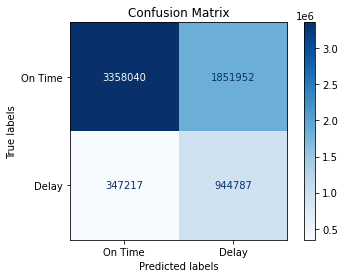

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_lr = confusion_matrix(y_true_lr, y_pred_lr)
cm_lr_display = ConfusionMatrixDisplay(cm_lr, display_labels=['On Time', 'Delay'])
cm_lr_display.plot(cmap='Blues', values_format='d')
cm_lr_display.ax_.set(title='Confusion Matrix')
cm_lr_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')

#### 4.2 Gradient Boosted Trees

**GBT Parameter Hypertuning**

In [0]:
# Cross Validation

gb = GBTClassifier(labelCol="departure_delay_boolean", featuresCol="VectorAssembler_features")
gbparamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [2, 5])
             .addGrid(gb.maxBins, [10, 20])
             .addGrid(gb.maxIter, [10, 15])              
             .build())
               

In [0]:
# Create 3-fold CrossValidator
gbevaluator = MulticlassClassificationEvaluator(labelCol='departure_delay_boolean', metricName='f1')
gbcv = CrossValidator(estimator = gb,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = gbevaluator,
                      numFolds = 3)

In [0]:
# GBT Parameter Hypertuning - only to be run for parameter hypertuning

gbcvModel = gbcv.fit(model_data_train)
print(gbcvModel)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
/databricks/spark/python/pyspark/ml/util.py:86: UserWarning: CrossValidator_475da2491772 fit call failed but some spark jobs may still running for unfinished trials. To address this issue, you should enable pyspark pinned thread mode.
 warnings.warn("{} fit call failed but some spark jobs "

--------------------------------------------------------------------------- 
 IllegalArgumentException Traceback (most recent call last)
 <command-2297543790306958> in <module> 
 1 # GBT Parameter Hypertuning - only to be run for parameter hypertuning 
 2 
 ----> 3 gbcvModel = gbcv . fit ( model_data_train ) 
 4 print ( gbcvModel ) 

 /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py in patched_method (self, *args, **kwargs) 
 28 call_succeeded = False 
 29 try : 
 ---> 30 result = original_method ( self , * args , ** kwargs ) 
 31 call_succeeded = True 
 32 return result

 /databricks/spark/python/pyspark/ml/base.py in fit (self, dataset, params) 
 159 return self . copy ( params ) . _fit ( dataset ) 
 160 else : 
 --> 161 return self . _fit ( dataset ) 
 162 else : 
 163 raise ValueError("Params must be either a param map or a list/tuple of param maps, "

 /databricks/spark/python/pyspark/ml/tuning.py in _fit (self, dataset) 
 709 subModels [ i ] [ j ] = subModel
 710 
 --> 711 _cancel_on_failure ( dataset . _sc , self . uid , sub_task_failed , calculate_metrics ) 
 712 validation . unpersist ( ) 
 713 train . unpersist ( ) 

 /databricks/spark/python/pyspark/ml/util.py in _cancel_on_failure (sc, uid, sub_task_failed, f) 
 88 "issue, you should enable pyspark pinned thread mode." 
 89 .format(uid))
 ---> 90 raise e
 91 
 92 old_job_group = sc . getLocalProperty ( "spark.jobGroup.id" ) 

 /databricks/spark/python/pyspark/ml/util.py in _cancel_on_failure (sc, uid, sub_task_failed, f) 
 82 if os . environ . get ( "PYSPARK_PIN_THREAD" , "false" ) . lower ( ) != "true" : 
 83 try : 
 ---> 84 return f ( ) 
 85 except Exception as e : 
 86 warnings.warn("{} fit call failed but some spark jobs "

 /databricks/spark/python/pyspark/ml/tuning.py in calculate_metrics () 
 703 return task ( ) 
 704 
 --> 705 for j , metric , subModel in pool . imap_unordered ( run_task , tasks ) : 
 706 metrics [ j ] += ( metric / nFolds ) 
 707 metrics_all [ i ] [ j ] = metric

 /usr/lib/python3.8/multiprocessing/pool.py in next (self, timeout) 
 866 if success : 
 867 return value
 --> 868 raise value
 869 
 870 __next__ = next # XXX 

 /usr/lib/python3.8/multiprocessing/pool.py in worker (inqueue, outqueue, initializer, initargs, maxtasks, wrap_exception) 
 123 job , i , func , args , kwds = task
 124 try : 
 --> 125 result = ( True , func ( * args , ** kwds ) ) 
 126 except Exception as e : 
 127 if wrap_exception and func is not _helper_reraises_exception : 

 /databricks/spark/python/pyspark/ml/tuning.py in run_task (task) 
 701 if sub_task_failed [ 0 ] : 
 702 raise RuntimeError ( "Terminate this task because one of other task failed." ) 
 --> 703 return task ( ) 
 704 
 705 for j , metric , subModel in pool . imap_unordered ( run_task , tasks ) : 

 /databricks/spark/python/pyspark/ml/tuning.py in singleTask () 
 68 
 69 def singleTask ( ) : 
 ---> 70 index , model = next ( modelIter ) 
 71 # TODO: duplicate evaluator to take extra params from input 
 72 # Note: Supporting tuning params in evaluator need update method 

 /databricks/spark/python/pyspark/ml/base.py in __next__ (self) 
 67 raise StopIteration ( "No models remaining." ) 
 68 self . counter += 1 
 ---> 69 return index , self . fitSingleModel ( index ) 
 70 
 71 def next ( self ) : 

 /databricks/spark/python/pyspark/ml/base.py in fitSingleModel (index) 
 124 
 125 def fitSingleModel ( index ) : 
 --> 126 return estimator . fit ( dataset , paramMaps [ index ] ) 
 127 
 128 return _FitMultipleIterator ( fitSingleModel , len ( paramMaps ) ) 

 /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py in patched_method (self, *args, **kwargs) 
 28 call_succeeded = False 
 29 try : 
 ---> 30 result = original_method ( self , * args , ** kwargs ) 
 31 call_succeeded = True 
 32 return result

 /databricks/spark/python/pyspark/ml/base.py in fit (self, dataset, params) 
 157 elif isinstance ( params , dict ) : 
 158 if params : 
 --> 159 return self . 

While our attempt to run the cross-validation was not sucessful during our last attempt to optimize the parameters. We had been previosuly able to find the best values for hyperparameters, those were maxDepth=10, maxBins=10, and maxIter=10, which is a combination of hyperparameters that achieved the highest average f1 score during the cross-validation process. These params have been used for running GBT algorithm below.

**GBT Algorithm Testing**

In [0]:
# Reference used for building Gradient Boosted tree model: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html

# Build a gradient boosted tree model

start_gbt = time.time()
gbt = GBTClassifier(featuresCol='VectorAssembler_features', 
              labelCol='departure_delay_boolean', 
              maxBins=10,
              maxDepth=10,
              minInstancesPerNode=10,
              minInfoGain=0.001,
              stepSize=0.2,
              maxIter=10, 
              )


# Setup pipeline
stages_gbtClassifier = [gbt]
pipeline_gbt = Pipeline(stages=stages_gbtClassifier)

# Train the GBT model
gbt_model = pipeline_gbt.fit(model_data_train)

gbpredictions = gbt_model.transform(model_data_test)

print(f'gbt model completed job in {time.time() - start_gbt} seconds.')
gbt_time_model = time.time() - start_gbt

gbt model completed job in 5821.804710865021 seconds.

**GBT Model Evaluation**

In [0]:
# print results with helper function

print_results(gbpredictions, 'GB', gbt_time_model)

Sensitivity: 63.08%
Specificity: 78.88%
False positive rate: 21.12%
False negative rate: 36.92%
Recall: 63.08%
Precision: 42.55%
f1: 50.82%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 815024 476980
Actual-on time 1100370 4109622

In [0]:
# Plot Confusion Matrix

cm_gbt = confusion_matrix(y_true_gbt, y_pred_gbt)
cm_gbt_display = ConfusionMatrixDisplay(cm_gbt, display_labels=['On Time', 'Delay'])
cm_gbt_display.plot(cmap='Blues', values_format='d')
cm_gbt_display.ax_.set(title='Confusion Matrix-Gradient Boosted Tree')
cm_gbt_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')